# Решающие деревья

In [1]:
import pandas as pd
import numpy as np

In [2]:
data = pd.DataFrame({
    'age': [17, 64, 18, 20, 38, 49, 55, 25, 29, 31],
    'income': [25, 80, 22, 36, 37, 59, 74, 70, 33, 102],
    'loan': [1, 0, 1, 0, 1, 0, 0, 1, 1, 0]
})
x = data['age']
y = data['loan']

1. Отсортировать факторы по возрастанию и удалить дубликаты

In [3]:
x = x.sort_values().drop_duplicates()
print(x.values)

[17 18 20 25 29 31 38 49 55 64]


2. Вычислить скользящее среднее

In [4]:
x_roll_mean = x.rolling(2).mean()
print(x_roll_mean.values)

[ nan 17.5 19.  22.5 27.  30.  34.5 43.5 52.  59.5]


3. Удалить пропуск

In [5]:
x_roll_mean = x_roll_mean.dropna()
print(x_roll_mean.values)

[17.5 19.  22.5 27.  30.  34.5 43.5 52.  59.5]


4. Необходимо отфильтровать x так, чтобы в результат попали только те значения, при переходе через которые целевая переменная меняется. Для этого мы отсортируем y в соответствии с индексами x, затем вычислим разницу между соседними значениями y с помощью метода diff(). После этого произведём фильтрацию:

In [6]:
y = y[x_roll_mean.index]
y_roll_mean = y.diff()
candidates = x_roll_mean[y_roll_mean != 0]
print(candidates.values)

[17.5 19.  22.5 30.  34.5 43.5]


Удобнее будет оформить полученный алгоритм в виде функции find_candidates_for_thresholds(). Она будет принимать на вход фактор x и целевую переменную y и возвращать кандидатов в пороговые значения для y в виде numpy-массива:

In [7]:
def find_candidates_for_thresholds(x, y):
    x =x.sort_values().drop_duplicates()
    x_roll_mean = x.rolling(2).mean().dropna()
    y = y[x_roll_mean.index]
    y_roll_mean = y.diff()
    candidates = x_roll_mean[y_roll_mean != 0]
    return candidates.values

In [8]:
print (find_candidates_for_thresholds(data['age'], data['loan']))
print (find_candidates_for_thresholds(data['income'], data['loan']))

[17.5 19.  22.5 30.  34.5 43.5]
[23.5 34.5 36.5 48.  64.5 72. ]


In [9]:
ames_data = pd.read_csv('data/AmesHousing.csv')
ames_data = ames_data[(ames_data['Lot Frontage'] <=150) & (ames_data['Lot Area'] <=20000)]
ames_sample = ames_data[['Lot Frontage', 'Lot Area', 'SalePrice']].sample(
    n=15, #количество объектов
    random_state=42, #генератор случайных чисел
    ignore_index=True #сбрасываем счетчик индекса
)

In [10]:
x=ames_sample['Lot Frontage']
y=ames_sample['SalePrice']

In [11]:
x=x.sort_values().drop_duplicates()

In [12]:
x_roll_mean=x.rolling(2).mean()
print (x_roll_mean)

3       NaN
8      53.0
0      58.0
14     61.0
2      65.0
9      69.0
7      71.0
5      76.0
4      86.0
1      94.0
12    101.0
Name: Lot Frontage, dtype: float64


In [13]:
x_roll_mean=x_roll_mean.dropna()

In [14]:
y=y[x_roll_mean.index]

In [15]:
y_roll_mean=y.diff()

In [16]:
y_roll_mean

8          NaN
0      10100.0
14     68000.0
2     -33875.0
9      32875.0
7      54800.0
5      76100.0
4    -101400.0
1     -11500.0
12    119500.0
Name: SalePrice, dtype: float64

In [17]:
candidates=x_roll_mean[y_roll_mean!=0]
print (candidates)

8      53.0
0      58.0
14     61.0
2      65.0
9      69.0
7      71.0
5      76.0
4      86.0
1      94.0
12    101.0
Name: Lot Frontage, dtype: float64


In [18]:
x_1=ames_sample['Lot Area']
y=ames_sample['SalePrice']

In [19]:
x_1=x_1.sort_values().drop_duplicates()
x1_roll_mean=x_1.rolling(2).mean()

In [20]:
x1_roll_mean=x1_roll_mean.dropna()

In [21]:
x1_roll_mean.index

Int64Index([8, 6, 14, 13, 12, 7, 3, 4, 2, 5, 1, 0, 11, 9], dtype='int64')

In [22]:
y=y[x1_roll_mean.index]
y_roll_mean=y.diff()


In [23]:
candidates=x1_roll_mean[y_roll_mean!=0]
print (candidates)

8      5508.0
6      7153.0
14     7425.0
13     7949.0
12     8405.5
7      8526.5
3      8850.0
4      9137.5
2      9466.0
5     10051.5
1     10507.0
0     10834.0
11    11365.0
9     12288.0
Name: Lot Area, dtype: float64


# Определение критерия информативности

Для начала создадим функцию для расчёта среднего квадрата ошибки — squared_error(). Она будет принимать на вход истинные ответы и возвращать значение MSE, рассчитанное для входных данных.

In [24]:
def squared_error(y):
    y_pred = y.mean()
    return ((y - y_pred) ** 2).mean()

Далее нам необходимо реализовать функцию split(), которая разбивает выборку  по предикату  с параметрами разделения (split_params) на левую и правую части:

In [25]:
def split(X, y, split_params):
    j, t = split_params
    predicat = X.iloc[:, j] <= t
    X_left, y_left = X[predicat], y[predicat]
    X_right, y_right = X[~predicat], y[~predicat]
    return X_left, y_left, X_right, y_right

Затем создадим функцию calculate_weighted_impurity(). Она будет принимать на вход выборку — X и y, параметры разбиения — split_params, а также criterion — функцию, по которой рассчитывается критерий информативности (у нас это функция squared_error()). Результатом работы функции будет взвешенная неоднородность после разбиения.

In [26]:
def calculate_weighted_impurity(X, y, split_params, criterion):
    X_left, y_left, X_right, y_right = split(X, y, split_params)
    N, N_left, N_right  = y.size, y_left.size, y_right.size
    score = N_left / N * criterion(y_left) + N_right / N * criterion(y_right)
    return score

Наконец, финальный шаг — построить решающий пень. Для этого необходимо оформить в виде цикла отбор кандидатов в параметры разбиения и найти оптимальные из них. За данный шаг будет отвечать функция best_split(). Она будет принимать на вход выборку (X и y) и возвращать оптимальные параметры разбиения, при которых значение взвешенной неоднородности минимально, а также значение этой неоднородности.

In [27]:
def best_split(X, y, criterion):
    M = X.shape[1]
    min_weighted_impurity = np.inf
    optimal_split_params = None
    for j in range(M):
        thresholds = find_candidates_for_thresholds(X.iloc[:, j], y)
        for t in thresholds:
            split_params = (j, t)
            weighted_impurity = calculate_weighted_impurity(X, y, split_params, criterion)
            if weighted_impurity < min_weighted_impurity:
                min_weighted_impurity = weighted_impurity
                optimal_split_params = split_params
    return optimal_split_params

In [28]:
data = pd.DataFrame({
    'x1': list(range(1, 16)),
    'y': [1, 1.2, 1.4, 1.1, 1, 5.5, 6.1, 6.7, 6.4, 6, 6, 3, 3.2, 3.1, 3]
})
X = data[['x1']]
y = data['y']

In [29]:
# Находим оптимальные параметры разбиения
optimal_split_params = best_split(X, y, criterion=squared_error)
print('Optimal j: {}'.format(optimal_split_params[0]))
print('Optimal t: {}'.format(optimal_split_params[1]))

Optimal j: 0
Optimal t: 5.5


или 

In [30]:
from sklearn import tree

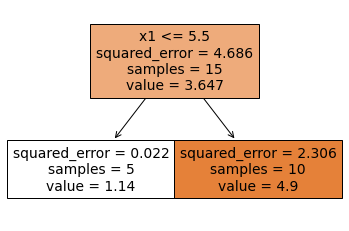

In [31]:
# Инициализируем модель дерева решений с максимальной глубиной 1 и обучаем её
dt = tree.DecisionTreeRegressor(
    max_depth=1, #глубина
    criterion='squared_error', #критерий информативности
    random_state=0 #генератор случайных чисел
)

dt.fit(X, y)
# Визуализируем дерево решений в виде графа
tree.plot_tree(
    decision_tree=dt, #дерево решений 
    feature_names=X.columns, #названия факторов
    filled=True, #расцветка
    impurity=True, #отображать ли неоднородность в вершинах
);

In [32]:
ames_data = pd.read_csv('data/AmesHousing.csv')
ames_data = ames_data[(ames_data['Lot Frontage'] <=150) & (ames_data['Lot Area'] <=20000)]
ames_sample = ames_data[['Lot Frontage', 'Lot Area', 'SalePrice']].sample(
    n=15, #количество объектов
    random_state=42, #генератор случайных чисел
    ignore_index=True #сбрасываем счетчик индекса
)

In [33]:
ames_sample

,Lot Frontage,Lot Area,SalePrice
0,60.0,11040,108000
1,96.0,10628,193000
2,68.0,9717,142125
3,50.0,9060,150909
4,92.0,9215,204500
5,80.0,10386,305900
6,60.0,7350,139000
7,72.0,8640,229800
8,56.0,6956,97900
9,70.0,12886,175000


In [34]:
X=ames_sample[['Lot Frontage', 'Lot Area']]
y=ames_sample['SalePrice']

In [35]:
optimal_split_params=best_split(X, y, criterion=squared_error)

In [36]:
optimal_split_params

(0, 71.0)

In [37]:
score = calculate_weighted_impurity(X, y, split_params=optimal_split_params, criterion=squared_error)

In [38]:
print (score)

1414654917.0222223


In [39]:
a = np.array([4.4, 3.8, 4.8, 4.0, 3.4, 4.2, 5.2])
b = a.mean()
np.sum((a - b)**2)/7

0.31673469387755115